## Introducción

Mediante una base de datos con distintos rostros de personas y sus respectivas edades reales, una empresa de supermercado busca estimar la edad de los clientes para evitar que aquellos menores de edad puedan comprar bebidas alcohólicas y otros productos. El código del modelo se establecerá mediante funciones pero dado que la carga computacional es elevada, el entrenamiento deberá realizarse en una plataforma GPU. Por ello, el entrenamiento no se desarrollará aquí, pero el código implicado y los resultados obtenidos sí se mostrarán.

## Objetivo 

Crear un modelo de reconocimiento de imágenes que estime la edad de distintos rostros con una métrica de evaluación, error absoluto medio, no mayor a 8.0.

## Carga los datos

### Cargar las librerías necesarias

In [1]:
# Librerías necesarias para el análisis de datos
import pandas as pd
import matplotlib.pyplot as plt

# Librerías necesarias para el desarrollo del modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  Flatten, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.resnet import ResNet50

### Cargar los datos con sus respectivas transformaciones

In [2]:
# Marco de datos 
y = pd.read_csv('/datasets/faces/labels.csv')

# Impagenes
data_gen = ImageDataGenerator(rescale=1/255)

datagen_flow = data_gen.flow_from_dataframe(dataframe = y, directory='/datasets/faces/final_files/', 
                                            color_mode='rgb', x_col = 'file_name', y_col='real_age', 
                                            target_size=(150,150), class_mode='raw', seed= 24601, batch_size=16)

Found 7591 validated image filenames.


## EDA

Comencemos observando la integridad de los datos objetivo y su distribución general.

In [3]:
# Primeras filas de la tabla
y.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [4]:
# Dimensiones del marco de datos
y.shape

(7591, 2)

In [5]:
# Búsqueda de valores ausentes
y.isna().sum()

file_name    0
real_age     0
dtype: int64

In [6]:
# Búsqueda de valores duplicados
y.duplicated().sum()

0

In [7]:
# Tipo de los datos
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
# Distribución general de las edades
y.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [9]:
# Porcentaje de personas menores de edad. 
(y[y['real_age']<19]['real_age'].count()/7591*100).round(2)

22.34

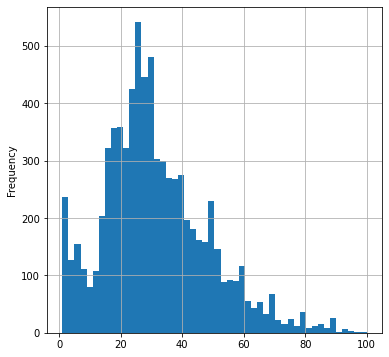

In [10]:
y['real_age'].plot(kind='hist', grid=True, bins=50, figsize=(6,6));

<AxesSubplot:ylabel='Frequency'>

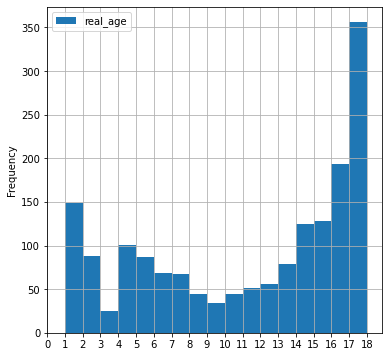

In [11]:
# Conteo de edades de los menores de edad
y.query('real_age < 19').plot(kind='hist', grid= True, bins=17, figsize=(6,6), xticks=(range(0,19)))

**Obervaciones generales**
- Los valores objetivo están completos, sin duplicados, con el tipo de datos correcto.
- Un cuarto de los sujetos en la base de datos es menor de edad.
- Tenemos menores de edad desde el año hasta los 17 años. El mayor número de menores de edad está a partir de los 13 años (exclusive).  

Para explorar las imágenes primero observaremos las dimensiones de los datos y después observaremos un pequeño conjunto de ellas.

In [12]:
# Crear un marco de datos con las dimensiones del conunto reordenado
indice = ['Lotes',
         'Par imágen vs Edad',
         'Imágenes/lote',
         'Filas',
         'Columnas',
         'Canales']

columna = ['Cantidad']

data = [len(datagen_flow), len(datagen_flow[0]), len(datagen_flow[0][0]), len(datagen_flow[0][0][0]), len(datagen_flow[0][0][0][0]), len(datagen_flow[0][0][0][0][0])]

dimensiones = pd.DataFrame(data, index= indice, columns = columna)

dimensiones

,Cantidad
Lotes,475
Par imágen vs Edad,2
Imágenes/lote,16
Filas,150
Columnas,150
Canales,3


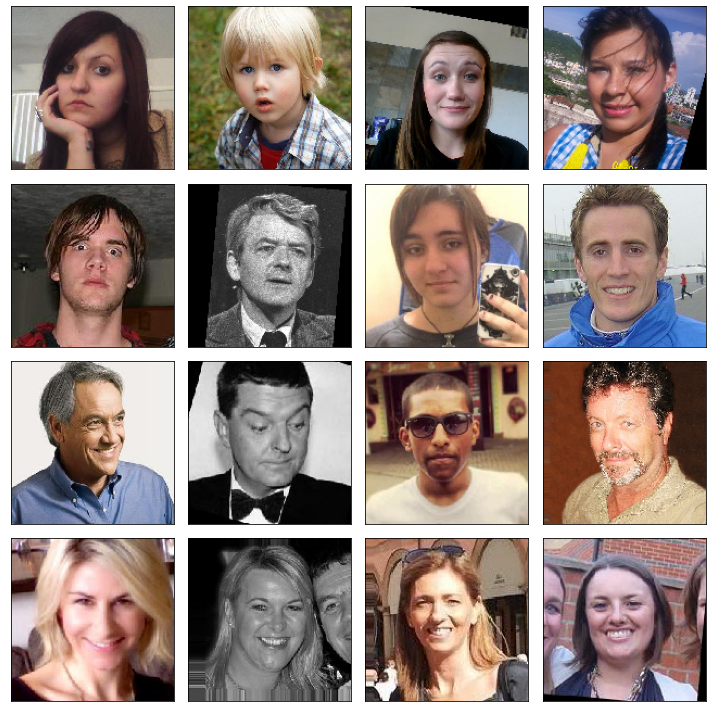

In [13]:
# Visualizar el primer lote de imágenes
batch1 = datagen_flow[0][0]
fig = plt.figure(figsize=(10,10))
for i in range(len(batch1)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(batch1[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

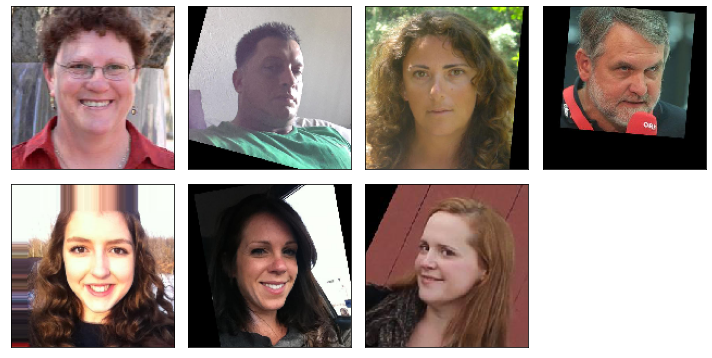

In [14]:
# Visualizar el último lote
batch475 = datagen_flow[474][0]
fig = plt.figure(figsize=(10,10))
for i in range(len(batch475)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(batch475[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [15]:
# Imágenes en el último lote
7591 % 16

7

**Observaciones:**

- Tenemos 475 lotes, con 16 imágenes cada uno, de dimensiones 150x150, con tres canales.
- Las imagenes corresponden a fotografías de los rostros de distintas personas con distintas características. Éstas pueden ser en blanco y negro o a color. Algunas están distorcionadas, rotadas, tienen fondos diversos o hay objetos obstruyendo el rostro como gafas o micrófonos.
- El primer lote es de 16 y el último lote es de 7. Esto se debe que se van haciendo lotes de 16 pero su múltiplo más cercano a 7591 es 7584, por lo que queda un lote final de 7 imágenes.

### Conclusiones sobre EDA

Los datos están completos y hay una imágen asociada a una edad. Por su parte, las imágenes tienen la ventaja de ser de distintas personas de múltiples edades y con características físicas diversas. Sin embargo, las imágenes no son enteramente homogéneas: hay fotografías con distintos fondos, de distintas definiciones, rostros con distintas expresiones faciales o tapadas parcialmente con objetos, poco iluminadas, tomadas desde distintos ángulos, o con encuadres distintos. Todo lo anterior podría hacer que el entrenamiento no sea tan eficiente. No obstante, si espera que el modelo pueda ser capaz de tomar estas variantes en consideración, una alternativa viable sería incrementar el número de imágenes con estas caracteríasticas junto con aquellas impagenes más "limpias".

Esto es posible si cargamos las imágenes con algunas modificaciones ligeras. La idea es modificar la imágen sin allanar sus características. Modificaciones válidas serían voltear la imágen de modo horizontal y girar la imágen no más de 30 grados para intentar integrar el hecho de que algunas imágenes presentan una ligera rotación. Debe recalcarse que estas modificaciones sólo deben aplicarse al conjunto de entrenamiento.

Otro aspecto interesate a mencionar es que se nos dan las edades reales de las personas pero no sus edades aparentes. La edad aparente y la real pueden diferir por distintos factores asociados a la edad de las personas o al cuidado de su piel. Pero el modelo no puede tomar en consideración estos múltiples factores por lo que cabe esperar que cierta parte de error se deba, no a un mal entrenamiento, sino a un ligero desajuste entre la edad real de una persona y su edad aparente.

## Modelado

En esta sección se definen las funciones necesarias para entrenar el modelo en la plataforma GP para, posteriormente, integrarlas en un sólo script que pueda ser entrenado en un GPU, dados los extensos recursos computacionales que requiere la tarea.

Para la estructura del modelo se usará como base el modelo ResNet50 con el optimizador Adam.

### Funciones en el script

In [17]:
# Función para cargar la parte de entrenamiento del modelo

def load_train(path):
    
    y = pd.read_csv(path + 'labels.csv')
    
    directory=path + 'final_files/'
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255), horizontal_flip=True, vertical_flip=False,
                                      rotation_range=30)
    
    train_gen_flow = train_datagen.flow_from_dataframe(y, directory=directory, subset='training',
                                                          batch_size=16, target_size=(150,150), seed=24601, x_col='file_name',
                                                          y_col='real_age', class_mode='raw')
    
    return train_gen_flow

In [18]:
# Función para cargar la parte de prueba del modelo

def load_test(path):
    
    y = pd.read_csv(path + 'labels.csv')
    directory=path + 'final_files/'

    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))
    
    test_gen_flow = val_datagen.flow_from_dataframe(y, directory=directory, subset='validation',
                                                          batch_size=16, target_size=(150,150), seed=24601, x_col='file_name',
                                                          y_col='real_age', class_mode='raw')

    return test_gen_flow

In [19]:
# Función para cargar la parte de estructuración del modelo

def create_model(input_shape):
    
     
    model = Sequential()
    
    resnet50 = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model.add(resnet50)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Flatten())
    

    model.add(Dense(36, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer= Adam(lr=0.00025)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [20]:
# Función de entrenamiento del modelo y presentación de los resultados.

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if steps_per_epoch is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data = test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, 
             validation_steps=validation_steps, verbose=2)

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Este sería el script implicado en el entrenamiento del modelo:

In [21]:
# Función para cargar el conjunto de entrenamiento
def load_train(path):

    y = pd.read_csv(path + 'labels.csv')
    directory=path + 'final_files/'
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255), horizontal_flip=True, vertical_flip=False,
                                      rotation_range=30)
    
    train_gen_flow = train_datagen.flow_from_dataframe(y, directory=directory, subset='training',
                                                          batch_size=16, target_size=(150,150), seed=24601, x_col='file_name',
                                                          y_col='real_age', class_mode='raw')

    return train_gen_flow

# Función para cargar el conjunto de validación 
def load_test(path):

    y = pd.read_csv(path + 'labels.csv')
    directory=path + 'final_files/'

    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))
    
    test_gen_flow = val_datagen.flow_from_dataframe(y, directory=directory, subset='validation',
                                                          batch_size=16, target_size=(150,150), seed=24601, x_col='file_name',
                                                          y_col='real_age', class_mode='raw')

    return test_gen_flow


# Función de definición del modelo
def create_model(input_shape):
    
    model = Sequential()
    
    resnet50 = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model.add(resnet50)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Flatten())
    
    model.add(Dense(36, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer= Adam(lr=0.00025)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    

    return model

# Función de entrenamiento del modelo

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if steps_per_epoch is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data = test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, 
             validation_steps=validation_steps, verbose=2)

    return model


### El resultado

Resultados de la plataforma GPU:

- Train for 356 steps, validate for 119 steps
- Epoch 1/7
- 2024-01-29 00:56:21.716364: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
- 2024-01-29 00:56:21.979305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
- 356/356 - 72s - loss: 221.0203 - mae: 11.1574 - val_loss: 390.9826 - val_mae: 14.8139
- Epoch 2/7
- 356/356 - 64s - loss: 138.9883 - mae: 9.0231 - val_loss: 258.0299 - val_mae: 11.7203
- Epoch 3/7
- 356/356 - 64s - loss: 118.0026 - mae: 8.3207 - val_loss: 122.0670 - val_mae: 8.8085
- Epoch 4/7
- 356/356 - 64s - loss: 106.8815 - mae: 7.8822 - val_loss: 120.2940 - val_mae: 8.3272
- Epoch 5/7
- 356/356 - 65s - loss: 98.0977 - mae: 7.5797 - val_loss: 146.6747 - val_mae: 8.8794
- Epoch 6/7
- 356/356 - 64s - loss: 84.8060 - mae: 7.0195 - val_loss: 148.6716 - val_mae: 9.4075
- Epoch 7/7
- 356/356 - 64s - loss: 77.3288 - mae: 6.6653 - val_loss: 85.9142 - val_mae: 6.9198
- WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
- 119/119 - 9s - loss: 85.9142 - mae: 6.9198
- Test MAE: 6.9198

Se logró alcanzar un valor menor a 8 en el conjunto de validación en la cuarta época. 

## Conclusiones

Los datos para entrenar y preparar el modelo consisitian en fotografías de rostros de distintas personas con su respectiva edad real. El marco de datos de las edades estaba completo y sin errores; el conjunto de imágenes tenía con distorciones como caldiades diferentes, imágenes con objetos obstruyendo el rostro o con ligeras rotaciones. El modelo utilizado consistió con una base del modelo popular ResNet50 al cual se le fueron provando las mejores combinaciones de capas totalmente conectadas con distitnas tasas de aprendizaje a partir del modelo Adam. Para el entrenamiento del modelo se consideró dar vuelta de manera horizontal a la imagen y aplicarle una ligera rotación de 30 grados. Se aplicaron 7 épocas al modelo y se logró un valor del error absoluto medio en el conjunto de entrenamiento de 6.91, es decir, muy por debajo de nuestro objetivo inicial. 